In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q timm ultralytics segment-anything opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from torchvision import transforms
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Cell 3: Load Ground Truth from .mat
mat_path = "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_1.mat"
data = scipy.io.loadmat(mat_path)
points = data['image_info'][0][0][0][0][0]  # Corrected: Fully closed indexing


In [4]:
def generate_density_map(image_shape, points, sigma=10):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x, y = min(int(point[0]), w-1), min(int(point[1]), h-1)
        density_map[y, x] += 1
    return gaussian_filter(density_map, sigma=sigma)

In [5]:
img_path = "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_1.jpg"
img = np.array(Image.open(img_path).convert('RGB'))
heatmap = generate_density_map(img.shape[:2], points, sigma=2)  # Try 3 or 5 instead of 10



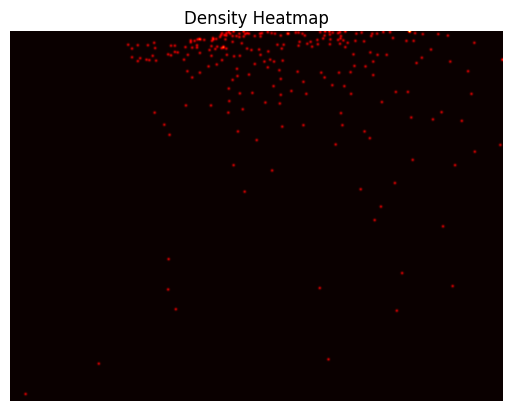

In [6]:
plt.imshow(heatmap, cmap='hot')
plt.title("Density Heatmap")
plt.axis('off')
plt.show()


In [7]:
coordinates = peak_local_max(heatmap, min_distance=2, threshold_abs=0.02)

In [8]:
print("Number of prompt points:", len(coordinates))


Number of prompt points: 213


In [9]:
sam_checkpoint = "/kaggle/input/sam/pytorch/default/1/sam_vit_h_4b8939.pth"  # Add SAM checkpoint here
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(img)
masks, scores, _ = predictor.predict(point_coords=coordinates[:, ::-1], point_labels=[1]*len(coordinates), multimask_output=False)


In [10]:
final_mask = np.zeros(img.shape[:2], dtype=np.uint8)
for mask in masks:
    heat = heatmap * mask
    if heat.sum() > 0.02:  # threshold on heat
        final_mask = np.logical_or(final_mask, mask)


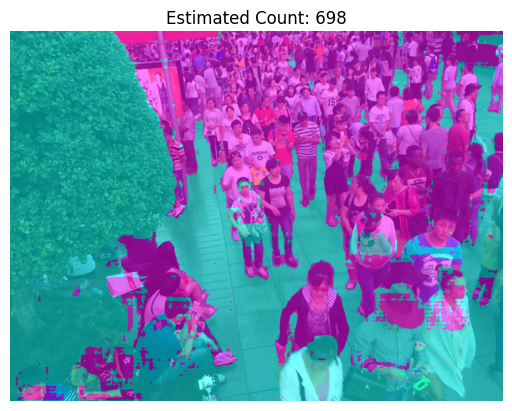

In [11]:
num_people = np.sum(final_mask) // 500  # Approximate per person pixel area
plt.imshow(img)
plt.imshow(final_mask, alpha=0.5, cmap='cool')
plt.title(f"Estimated Count: {num_people}")
plt.axis('off')
plt.show()


In [1]:
!pip install segment-anything opencv-python-headless torch torchvision tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Paths
train_img_dir = "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images"
train_gt_dir = "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth"
test_img_dir = "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images"
test_gt_dir = "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth"

# Check train images
train_images = sorted(os.listdir(train_img_dir))
print(f"Number of training images: {len(train_images)}")
print(f"Example image: {train_images[:3]}")


Number of training images: 400
Example image: ['IMG_1.jpg', 'IMG_10.jpg', 'IMG_100.jpg']


In [3]:
from tqdm import tqdm


In [4]:
def create_mask_from_points(img_path, mat_path, radius=6):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    mat = scipy.io.loadmat(mat_path)
    points = mat['image_info'][0][0][0][0][0]  # (N, 2) array of points

    for x, y in points:
        cv2.circle(mask, (int(x), int(y)), radius, 255, -1)
    return mask

# Create and save masks for all training images
os.makedirs("masks/train", exist_ok=True)

for fname in tqdm(train_images):
    img_path = os.path.join(train_img_dir, fname)
    mat_path = os.path.join(train_gt_dir, "GT_" + fname.replace(".jpg", ".mat"))
    mask = create_mask_from_points(img_path, mat_path)
    cv2.imwrite(f"masks/train/{fname.replace('.jpg', '.png')}", mask)


100%|██████████| 400/400 [00:07<00:00, 50.06it/s]


In [5]:
from segment_anything import SamPredictor, sam_model_registry
import torch

# Load pretrained SAM
sam_checkpoint = "/kaggle/input/sam/pytorch/default/1/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Example prompting function
def get_sam_mask(image, grid_spacing=50):
    h, w = image.shape[:2]
    grid_points = [(x, y) for y in range(0, h, grid_spacing) for x in range(0, w, grid_spacing)]
    coords = np.array(grid_points)

    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=coords, 
        point_labels=[1] * len(coords), 
        multimask_output=False
    )
    return np.sum(masks, axis=0) > 0


In [6]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Dataset class
class CrowdDataset(Dataset):
    def __init__(self, img_dir, mask_dir, gt_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.gt_dir = gt_dir
        self.img_names = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        fname = self.img_names[idx]
        img_path = os.path.join(self.img_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname.replace(".jpg", ".png"))
        mat_path = os.path.join(self.gt_dir, "GT_" + fname.replace(".jpg", ".mat"))

        img = cv2.imread(img_path)
        sam_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize to [0, 1]
        gt_count = len(scipy.io.loadmat(mat_path)['image_info'][0][0][0][0][0])  # Total points

        return torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0, \
               torch.tensor(sam_mask, dtype=torch.float32).unsqueeze(0), \
               torch.tensor([gt_count], dtype=torch.float32)

# Define CNN head
class CountHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Dataset and DataLoader
train_dataset = CrowdDataset(train_img_dir, "masks/train", train_gt_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CountHead().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for img, sam_mask, gt_count in train_loader:
        sam_mask, gt_count = sam_mask.to(device), gt_count.to(device)
        pred_count = model(sam_mask)
        loss = criterion(pred_count, gt_count)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1, Loss: 24026.3008
Epoch 2, Loss: 23988.8912
Epoch 3, Loss: 23945.8303
Epoch 4, Loss: 23898.2546
Epoch 5, Loss: 23840.4095
Epoch 6, Loss: 23770.2882
Epoch 7, Loss: 23686.5325
Epoch 8, Loss: 23588.6291
Epoch 9, Loss: 23474.1530
Epoch 10, Loss: 23341.5481
Epoch 11, Loss: 23191.7129
Epoch 12, Loss: 23021.0914
Epoch 13, Loss: 22833.3100
Epoch 14, Loss: 22624.5924
Epoch 15, Loss: 22395.3610
Epoch 16, Loss: 22144.9839
Epoch 17, Loss: 21867.1583
Epoch 18, Loss: 21558.5720
Epoch 19, Loss: 21229.5891
Epoch 20, Loss: 20876.7951
Epoch 21, Loss: 20504.4002
Epoch 22, Loss: 20085.7048
Epoch 23, Loss: 19635.1417
Epoch 24, Loss: 19150.4814
Epoch 25, Loss: 18654.8446
Epoch 26, Loss: 18142.3952
Epoch 27, Loss: 17625.5255
Epoch 38, Loss: 11615.2236
Epoch 39, Loss: 11144.3145
Epoch 40, Loss: 10696.4868
Epoch 41, Loss: 10278.7493
Epoch 42, Loss: 9886.9555
Epoch 43, Loss: 9522.7214
Epoch 44, Loss: 9184.8996
Epoch 45, Loss: 8874.3016
Epoch 46, Loss: 8572.7467
Epoch 47, Loss: 8317.8683
Epoch 48, Loss: 

In [7]:
test_dataset = CrowdDataset(test_img_dir, "masks/train", test_gt_dir)
test_loader = DataLoader(test_dataset, batch_size=1)

model.eval()
mae, mse = 0, 0
with torch.no_grad():
    for img, sam_mask, gt_count in test_loader:
        sam_mask, gt_count = sam_mask.to(device), gt_count.to(device)
        pred_count = model(sam_mask)
        mae += torch.abs(pred_count - gt_count).item()
        mse += ((pred_count - gt_count)**2).item()

mae /= len(test_loader)
mse = (mse / len(test_loader))**0.5
print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")


MAE: 72.70, RMSE: 96.14


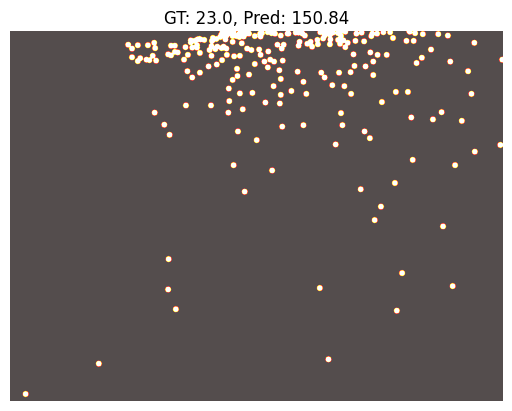

In [8]:
for img, sam_mask, gt_count in test_loader:
    sam_mask_np = sam_mask[0].cpu().squeeze().numpy()
    sam_tensor = torch.tensor(sam_mask_np).unsqueeze(0).unsqueeze(0).to(device)
    pred_count = model(sam_tensor).item()
    
    plt.imshow(sam_mask_np, cmap='hot', alpha=0.7)
    plt.title(f"GT: {gt_count.item()}, Pred: {pred_count:.2f}")
    plt.axis('off')
    plt.show()
    break


herre 2

In [13]:
import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm

In [15]:
from segment_anything import sam_model_registry, SamPredictor

In [31]:
def load_mat_points(mat_path):
    mat = scipy.io.loadmat(mat_path)
    return mat['image_info'][0][0][0][0][0]

In [32]:
class CrowdSAMPipelineDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.filenames = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        mat_path = os.path.join(self.gt_dir, "GT_" + fname.replace(".jpg", ".mat"))
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        points = load_mat_points(mat_path)

        if self.transform:
            img_tensor = self.transform(img_rgb)
        else:
            img_tensor = torch.tensor(img_rgb.transpose(2, 0, 1)).float() / 255.

        return img_rgb, img_tensor, points, fname

In [33]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [34]:
train_dataset = CrowdSAMPipelineDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images",
                                        "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth",
                                        transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = CrowdSAMPipelineDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images",
                                       "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth",
                                       transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1)

In [35]:
sam_checkpoint = "/kaggle/input/sam/pytorch/default/1/sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [36]:
def generate_sam_mask(img_rgb, gt_points):
    predictor.set_image(img_rgb)
    coords = np.array(gt_points)
    if len(coords) == 0:
        return np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    masks, scores, _ = predictor.predict(point_coords=coords, point_labels=[1]*len(coords), multimask_output=False)
    final_mask = np.any(masks, axis=0).astype(np.uint8)
    return final_mask


In [37]:
class SAMCountHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.cnn(x)


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAMCountHead().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for img_rgb_raw, _, points, _ in tqdm(train_loader):
        img_rgb = img_rgb_raw[0].numpy().transpose(1, 2, 0) * 255
        img_rgb = img_rgb.astype(np.uint8)
        mask = generate_sam_mask(img_rgb, points[0])
        mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float().to(device)
        gt_count = torch.tensor([[len(points[0])]]).float().to(device)


        pred = model(mask_tensor)
        loss = criterion(pred, gt_count)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")



  0%|          | 0/400 [00:00<?, ?it/s]


ValueError: pic should not have > 4 channels. Got 768 channels.

In [ ]:
model.eval()
mae = 0
with torch.no_grad():
    for img_rgb_raw, _, points, _ in tqdm(train_loader):
        img_rgb = img_rgb_raw[0].numpy().transpose(1, 2, 0) * 255
        img_rgb = img_rgb.astype(np.uint8)
        mask = generate_sam_mask(img_rgb, points[0])
        mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float().cuda()
        pred = model(mask_tensor).item()
        gt = len(points[0])
        mae += abs(pred - gt)
        plt.imshow(mask, cmap='hot')
        plt.title(f"GT: {gt}, Pred: {pred:.2f}")
        plt.show()
        break  # visualize one only

print(f"Test MAE: {mae / len(test_loader):.2f}")


In [ ]:
#here 3


here 3

In [9]:
import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm

from segment_anything import sam_model_registry, SamPredictor


In [10]:
def load_mat_points(mat_path):
    mat = scipy.io.loadmat(mat_path)
    return mat['image_info'][0][0][0][0][0] 

In [11]:
class CrowdSAMPipelineDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.filenames = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        mat_path = os.path.join(self.gt_dir, "GT_" + fname.replace(".jpg", ".mat"))
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        points = load_mat_points(mat_path)

        if self.transform:
            img_tensor = self.transform(img_rgb)
        else:
            img_tensor = torch.tensor(img_rgb.transpose(2, 0, 1)).float() / 255.

        return img_rgb, img_tensor, points, fname


In [12]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [13]:
train_dataset = CrowdSAMPipelineDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images",
                                        "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth",
                                        transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = CrowdSAMPipelineDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images",
                                       "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth",
                                       transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1)

In [14]:
sam_checkpoint = "/kaggle/input/sam/pytorch/default/1/sam_vit_h_4b8939.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

In [15]:
def generate_sam_mask(img_rgb, gt_points):
    predictor.set_image(img_rgb)
    coords = np.array(gt_points)
    if len(coords) == 0:
        return np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    masks, scores, _ = predictor.predict(point_coords=coords, point_labels=[1]*len(coords), multimask_output=False)
    final_mask = np.any(masks, axis=0).astype(np.uint8)
    return final_mask


In [16]:
class SAMCountHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.cnn(x)


In [17]:
model = SAMCountHead().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [ ]:
epochs = 26
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for img_rgb_np, img_tensor, points, _ in tqdm(train_loader):
        img_rgb = img_rgb_np[0].numpy().astype(np.uint8)
        mask = generate_sam_mask(img_rgb, points[0])
        mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float().cuda()
        gt_count = torch.tensor([[len(points[0])]]).float().cuda()

        pred = model(mask_tensor)
        loss = criterion(pred, gt_count)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


100%|██████████| 400/400 [13:45<00:00,  2.06s/it]


Epoch 1, Loss: 9432423.8615


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 2, Loss: 8751227.4977


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 3, Loss: 7514000.4225


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 4, Loss: 6062866.9520


100%|██████████| 400/400 [13:45<00:00,  2.06s/it]


Epoch 5, Loss: 4751523.2402


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 6, Loss: 3805417.6726


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 7, Loss: 3250501.5346


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 8, Loss: 2976464.2828


100%|██████████| 400/400 [13:46<00:00,  2.07s/it]


Epoch 9, Loss: 2857407.7914


 71%|███████   | 283/400 [09:44<04:01,  2.07s/it]

In [ ]:
# 9. Evaluate
model.eval()
mae = 0
with torch.no_grad():
    for img_rgb_np, _, points, _ in test_loader:
        img_rgb = img_rgb_np[0].astype(np.uint8)
        mask = generate_sam_mask(img_rgb, points[0])
        mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float().cuda()
        pred = model(mask_tensor).item()
        gt = len(points[0])
        mae += abs(pred - gt)
        plt.imshow(mask, cmap='hot')
        plt.title(f"GT: {gt}, Pred: {pred:.2f}")
        plt.show()
        break

print(f"Test MAE: {mae / len(test_loader):.2f}")
